In [1]:
import pandas as pd
import altair as alt
alt.renderers.set_embed_options(theme='dark')
pd.set_option('display.max_colwidth', None)

# Analysis & Charts

In [2]:
def claim(claim_hash):
    try:
        df_claim = pd.read_json(
            f'https://node-api.flipsidecrypto.com/api/v2/queries/{claim_hash}/data/latest',
            convert_dates=["BLOCK_TIMESTAMP"],
        )
    except Exception as e:
        print(e)
        return 
    return df_claim

In [3]:
class DataProvider:    
    
    def __init__(self):
        self.vote = 'a3efd3f0-724b-4a26-9f92-6083c7c52785'
        self.date_wallet = '074c2ad1-a842-442d-a0f5-6456b35be648'
    
    def get_vote(self):
        df = claim(self.vote)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_date_wallet(self):
        df = claim(self.date_wallet)
        df.columns = [c.lower() for c in df.columns]
        return df
    
   

In [4]:
dp = DataProvider()

In [5]:
df = dp.get_vote()[['date', 'address', 
       'block_timestamp', 'tx_id',
       'proposal_id', 'option', 'voting_power',  'balance','currency']]
df.head()

,date,address,block_timestamp,tx_id,proposal_id,option,voting_power,balance,currency
0,2022-05-20,terra106cf72933qmfvreay2nmj97rxclnj9w5e24pml,2022-05-20 17:48:46.532,1AB224780DB99795F2623BF2343425E7D6AA5F1D11C3316413610A926E001EC4,1623,VOTE_OPTION_YES,NaN,0.000000,LUNA
1,2022-05-18,terra1nr0x05rtyj6hacdkrj3elp5llfxs38ah9zvdpq,2022-05-18 12:11:38.947,283B565A695AD9F3A5EE0E2E3EE2FE52E5C9C66367726956A558C7D681570259,1623,VOTE_OPTION_YES,NaN,0.000000,LUNA
2,2022-05-18,terra1n3yxatqcwvquk03yh8799gzm6697nqdsz4fhwf,2022-05-18 13:28:05.617,BEDA9BB487571AFC14ECF79AC97ED8259498097BD7D6DAADBEBE75F9B4ED4345,1623,VOTE_OPTION_YES,NaN,697.832005,LUNA
3,2022-05-18,terra1v5dqd8fdck68tlqveulqwctdctrcl59ydyrem2,2022-05-18 12:07:26.033,4E113C13178ED75896C5E759796E2F29CE71F40DEDB41005FF1654CA701A1FF2,1623,VOTE_OPTION_YES,NaN,0.000000,LUNA
4,2022-05-18,terra1npkl36stde4lu65e39m0377ycvra3a7g709d05,2022-05-18 20:03:27.426,BAD4C0B4A937003B8323FCFE608C97086103C84A2B736866175C77065217FDAD,1623,VOTE_OPTION_YES,NaN,0.000000,LUNA


In [6]:
df.set_index('tx_id').to_json('../data/votes_tx.json')

In [7]:
df.option.unique()

array(['VOTE_OPTION_YES', 'VOTE_OPTION_NO', 'VOTE_OPTION_NO_WITH_VETO',
       'VOTE_OPTION_ABSTAIN'], dtype=object)

In [8]:
df['hours_since_start'] = (df.block_timestamp - df.block_timestamp.min()).apply(lambda x: x.total_seconds() / 3600)

In [9]:
df.option = df.option.map({'VOTE_OPTION_NO_WITH_VETO':'No with veto',
               'VOTE_OPTION_YES':'Yes',
               'VOTE_OPTION_NO':'No',
               'VOTE_OPTION_ABSTAIN':'Abstain'})

In [10]:
df.to_json('../data/votes.json',orient='records')

In [11]:
wc = dp.get_date_wallet()
wc['date'] = wc['min(date)']
wc['age'] = (pd.Timestamp('2022-05-20') - pd.to_datetime(wc.date)).apply(lambda x: x.total_seconds()/3600/24)

In [12]:
def typew(date):
    if(date<'2021-09-30'):
        return 'Pre-Col5'
    if((date>='2021-09-30')&(date<='2022-05-07')):
        return 'Post-Col5'
    if((date>'2021-05-07')):
        return 'Post-DePeg'

wc['typew'] = wc.date.apply(typew)

In [13]:
df.merge(wc[['address','age']], on='address', how='left').to_json('../data/votes.json',orient='records')

In [14]:
m = wc.merge(df, on='address')

<AxesSubplot:title={'center':'Number of Users'}>

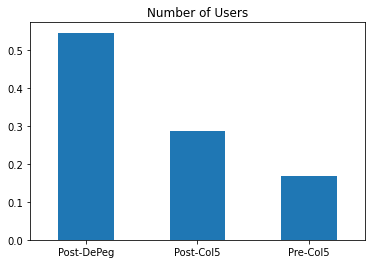

In [15]:
m.typew.value_counts(normalize=True).plot(kind='bar',rot=0, title='Number of Users')

<AxesSubplot:title={'center':'Voting Power'}, xlabel='typew'>

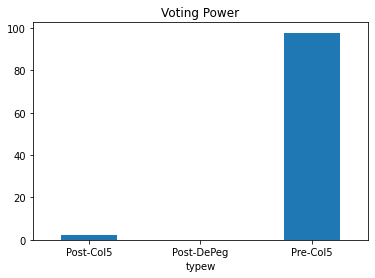

In [16]:
dfm = (m.groupby('typew').balance.sum())/1000000
(dfm/dfm.sum()*100).plot(kind='bar', rot=0, title='Voting Power')

<AxesSubplot:title={'center':'Pre-Col5'}>

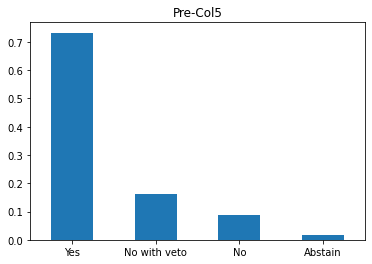

In [18]:
t='Pre-Col5'
m[m.typew==t].option.value_counts(normalize=True).plot(kind='bar', rot=0, title=t)

In [19]:
m[m.typew=='Post-DePeg'].option.value_counts(normalize=True)

Yes             0.739714
No with veto    0.201544
No              0.055197
Abstain         0.003545
Name: option, dtype: float64

In [20]:
m[m.typew=='Post-Col5'].option.value_counts(normalize=True)

Yes             0.627249
No with veto    0.234828
No              0.128568
Abstain         0.009355
Name: option, dtype: float64

In [21]:
m[m.typew=='Pre-Col5'].option.value_counts(normalize=True)

Yes             0.732616
No with veto    0.162252
No              0.088576
Abstain         0.016556
Name: option, dtype: float64